In [31]:
from iads import loading_data as loader
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re

import warnings
warnings.filterwarnings('ignore')

# Chargement des données

bson -> DF

In [32]:
df_avis = loader.load_dataframe("avis.bson")

In [33]:
df_jeux = loader.load_dataframe("details.bson")

1. Existence des jeux dupliqués

On supprime l'attribut `_id` généré par le `scrapping` pour mettre en evidences la duplication des jeux

In [34]:
df_jeux_up = df_jeux.drop(["_id"], axis=1)
df_jeux_up = df_jeux_up.drop_duplicates()

In [35]:
len_before = len(df_jeux)
len_after  = len(df_jeux_up)

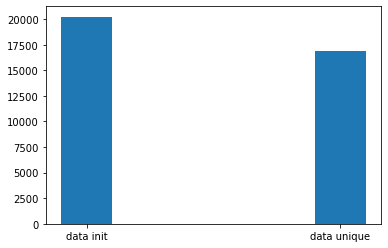

In [36]:
plt.bar(['data init', 'data unique'], [len_before, len_after], width=0.2)
plt.show()

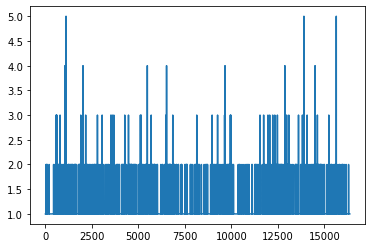

In [37]:
val, counts = np.unique(df_jeux_up["titre"], return_counts=True)

plt.plot(counts)
plt.show()

2. Version des jeux !!

In [38]:
list_same_title = []

for v in val[counts != 1]:
    a = df_avis[df_avis["title"] == v]
    
    if len(a) > 1:
        list_same_title.append(a)

In [39]:
list_same_title[1].head()

,title,note,author,url,comment,_id,review_href,date_published,treated,title_review
163033,1830,5.4,Mesophylle,https://www.trictrac.net/jeu-de-societe/1830-0...,"Un petit wargame assez light, aux règles très ...",63c67b8a993b727dc2a9c9ce,https://www.trictrac.net/avis/pour-les-belges-...,2013-03-12 14:23:55,True,Pour les Belges (et surtout Bruxellois) friand...
241489,1830,10.0,20.100,https://www.trictrac.net/jeu-de-societe/1830/a...,Le plus intéressant avec ce jeu est que le has...,63c68339993b727dc2aafc46,https://www.trictrac.net/avis/le-bonheur-d-etr...,2001-11-19 12:28:35,True,le bonheur d'être le meilleur
241490,1830,10.0,maksen,https://www.trictrac.net/jeu-de-societe/1830/a...,Il faut pas mal de combustible pour s'attaquer...,63c68339993b727dc2aafc47,https://www.trictrac.net/avis/fais-chauffer-la...,2012-09-11 12:29:05,True,Fais chauffer la chaudière !
241491,1830,10.0,Elendriel,https://www.trictrac.net/jeu-de-societe/1830/a...,Le premier de la série déclancheur de l'engoue...,63c68339993b727dc2aafc48,https://www.trictrac.net/avis/le-premier-4,2011-11-07 12:29:02,True,le premier
241492,1830,10.0,Wufnir,https://www.trictrac.net/jeu-de-societe/1830/a...,Les pertie que j'ai faites se sont terminées d...,63c68339993b727dc2aafc49,https://www.trictrac.net/avis/excellent-82,2005-07-29 12:28:39,True,Excellent


In [40]:
def update_title_jeux(arr):
    title = arr["titre"]
    title = re.sub(r'https://www.trictrac.net/jeu-de-societe/(.*)/?.*', r'\1', arr["url"])
    return title

df_jeux_up["_id"] = df_jeux_up.apply(update_title_jeux, axis=1)

df_jeux_up.head()

,Nombre d'avis rectifiés,Note rectifiée,url,Note Finkel,Nombre d'avis,titre,casting,Note,categories,description,gameplay,full_title,_id
0,10.0,8.40,https://www.trictrac.net/jeu-de-societe/marvel...,8.74,19.0,Marvel United,Par Eric Lang et Andrea ChiarvesioIllustré par...,7.58,NaN,\n Marvel United : Unis c...,1 à 4|14 ans et +|45,Marvel United (2020),marvel-united
1,17.0,7.29,https://www.trictrac.net/jeu-de-societe/mariposas,7.68,33.0,Mariposas,Par Elizabeth HargraveIllustré par Matt Paquet...,7.39,NaN,"\n Chaque année, au print...",2 à 5|14 ans et +|60,Mariposas (2020),mariposas
2,9.0,7.22,https://www.trictrac.net/jeu-de-societe/quetzal,7.42,28.0,Quetzal,Par Alexandre GarciaIllustré par Nastya LehnÉd...,8.18,Enchères|Aventures dans la jungle|Collection /...,\n Vous êtes à la tête d’...,2 à 5|8 ans et +|45,Quetzal (2020),quetzal
3,0.0,0.00,https://www.trictrac.net/jeu-de-societe/alien-...,0.00,4.0,Alien - Kit de Démarrage,Édité par Arkhane Asylum Publishing,9.00,NaN,\n Un Kit de démarrage co...,à partir de 1|12 ans et +|~,Alien - Kit de Démarrage (2020),alien-kit-de-demarrage
4,24.0,8.79,https://www.trictrac.net/jeu-de-societe/the-loop,9.70,72.0,The LOOP,Par Maxime Rambourg et Théo RivièreIllustré pa...,8.75,Card-driven|Combinaison|Coopération|Deck build...,\n Le Dr Foo a créé une t...,1 à 4|12 ans et +|60,The LOOP (2020),the-loop


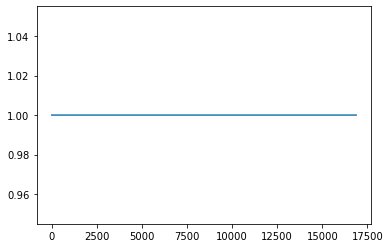

In [41]:
val, counts = np.unique(df_jeux_up["_id"], return_counts=True)

plt.plot(counts)
plt.show()

In [42]:
df_jeux_up.head()

,Nombre d'avis rectifiés,Note rectifiée,url,Note Finkel,Nombre d'avis,titre,casting,Note,categories,description,gameplay,full_title,_id
0,10.0,8.40,https://www.trictrac.net/jeu-de-societe/marvel...,8.74,19.0,Marvel United,Par Eric Lang et Andrea ChiarvesioIllustré par...,7.58,NaN,\n Marvel United : Unis c...,1 à 4|14 ans et +|45,Marvel United (2020),marvel-united
1,17.0,7.29,https://www.trictrac.net/jeu-de-societe/mariposas,7.68,33.0,Mariposas,Par Elizabeth HargraveIllustré par Matt Paquet...,7.39,NaN,"\n Chaque année, au print...",2 à 5|14 ans et +|60,Mariposas (2020),mariposas
2,9.0,7.22,https://www.trictrac.net/jeu-de-societe/quetzal,7.42,28.0,Quetzal,Par Alexandre GarciaIllustré par Nastya LehnÉd...,8.18,Enchères|Aventures dans la jungle|Collection /...,\n Vous êtes à la tête d’...,2 à 5|8 ans et +|45,Quetzal (2020),quetzal
3,0.0,0.00,https://www.trictrac.net/jeu-de-societe/alien-...,0.00,4.0,Alien - Kit de Démarrage,Édité par Arkhane Asylum Publishing,9.00,NaN,\n Un Kit de démarrage co...,à partir de 1|12 ans et +|~,Alien - Kit de Démarrage (2020),alien-kit-de-demarrage
4,24.0,8.79,https://www.trictrac.net/jeu-de-societe/the-loop,9.70,72.0,The LOOP,Par Maxime Rambourg et Théo RivièreIllustré pa...,8.75,Card-driven|Combinaison|Coopération|Deck build...,\n Le Dr Foo a créé une t...,1 à 4|12 ans et +|60,The LOOP (2020),the-loop


In [48]:
def parse_casting(castings):
    castings = str(castings)
    castings = re.sub(r'(.*) De (.*)', r'\1 Par \2', castings)
    castings = re.sub(r'(Par|Illustré|Édité|Distribué|De)', r'\n\1', castings)

    castings = castings.split("\n")
    
    if "" in castings:
        castings.remove("")
        
    return castings

def extract_creators(arr):
    castings = parse_casting(arr["casting"])
    creators = np.NaN
    
    for cas in castings:
        if cas.startswith("Par"):
            creators = cas.replace("Par ", "")
            return creators
        
        if cas.startswith("De"):
            creators = cas.replace("De ", "")
            return creators
    
    return creators

def extract_illustrators(arr): 
    castings = parse_casting(arr["casting"])
    illustrators = np.NaN
    
    for cas in castings:
        if cas.startswith("Illustré"):
            illustrators = cas.replace("Illustré par ", "")
            return illustrators
    
    return illustrators

def extract_editors(arr):
    castings = parse_casting(arr["casting"])       
    editors = np.NaN
    
    for cas in castings:
        if cas.startswith("Édité"):
            editors = cas.replace("Édité par ", "")
            return editors
    
    return editors

def extract_distributors(arr):

    castings = parse_casting(arr["casting"])
    distributors = np.NaN
    
    for cas in castings:
        if cas.startswith("Distribué"):
            distributors = cas.replace("Distribué par ", "")
            return distributors
    
    return distributors


df_jeux_up["creators"] = df_jeux_up.apply(extract_creators, axis=1)
df_jeux_up["illustrators"] = df_jeux_up.apply(extract_illustrators, axis=1)
df_jeux_up["editors"] = df_jeux_up.apply(extract_editors, axis=1)
df_jeux_up["distributors"] = df_jeux_up.apply(extract_distributors, axis=1)

,Nombre d'avis rectifiés,Note rectifiée,url,Note Finkel,Nombre d'avis,titre,casting,Note,categories,description,gameplay,full_title,_id,creators,illustrators,editors,distributors
118,0.0,0.00,https://www.trictrac.net/jeu-de-societe/board-...,0.00,0.0,Board Trotter,NaN,0.00,Casual|Jeux de plateau|Course|Exploration|Loco...,\n Board Trotter\nEn quêt...,2 à 5|12 à 120 |90,Board Trotter (2018),board-trotter,NaN,NaN,NaN,NaN
167,0.0,0.00,https://www.trictrac.net/jeu-de-societe/2184-g...,0.00,2.0,2184 Generation War 2.0,NaN,8.90,Affrontement|Jeux de figurines|Science fiction,"\n 2184 GENERATION WAR, l...",2 à 6|8 à 120 |60,2184 Generation War 2.0 (2019),2184-generation-war-2-0,NaN,NaN,NaN,NaN
183,39.0,7.36,https://www.trictrac.net/jeu-de-societe/skyjo,8.22,134.0,Skyjo,NaN,7.36,NaN,\n Skyjo est un jeu passi...,2 à 8|8 à 99 |30,Skyjo (2019),skyjo,NaN,NaN,NaN,NaN
212,1.0,10.00,https://www.trictrac.net/jeu-de-societe/silmaris,10.05,1.0,Silmaris,NaN,10.00,Jeu en ligne|Livre dont vous êtes le héros|Méd...,\n - Un univers sombre et...,1 |16 ans et +|~,Silmaris (2019),silmaris,NaN,NaN,NaN,NaN
625,1.0,6.70,https://www.trictrac.net/jeu-de-societe/the-en...,6.72,2.0,The Enigma Box,NaN,7.85,Coopération|Exploration|Historique|Enigme,\n Jeu d'énigmes à base h...,1 à 4|12 ans et +|1500,The Enigma Box (2017),the-enigma-box,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20088,0.0,0.00,https://www.trictrac.net/jeu-de-societe/droles...,0.00,0.0,Drôles de courses !,NaN,0.00,Jeux de plateau,\n Faites vos courses dan...,2 à 6|6 ans et +|~,Drôles de courses !,droles-de-courses,NaN,NaN,NaN,NaN
20110,2.0,9.25,https://www.trictrac.net/jeu-de-societe/vivez-...,9.34,2.0,Vivez L'Aventure !,NaN,9.25,Amateur|Livre dont vous êtes le héros|Parcours...,\n La série des livres-je...,à partir de 1|9 ans et +|30,Vivez L'Aventure ! (1985),vivez-l-aventure,NaN,NaN,NaN,NaN
20150,3.0,7.07,https://www.trictrac.net/jeu-de-societe/corn-hole,7.13,3.0,Corn Hole,NaN,7.07,NaN,\n Jeu d'habileté traditi...,4 |7 ans et +|20,Corn Hole,corn-hole,NaN,NaN,NaN,NaN
20176,1.0,9.00,https://www.trictrac.net/jeu-de-societe/catanb...,9.04,1.0,Catanbox Deluxe,NaN,9.00,Autres,\n Boite en bois pour ran...,jusqu'à 2|~|~,Catanbox Deluxe,catanbox-deluxe,NaN,NaN,NaN,NaN


In [61]:

tmp = df_jeux_up[df_jeux_up["creators"].isna() & df_jeux_up["illustrators"].isna() & df_jeux_up["distributors"].isna() & df_jeux_up["editors"].isna()]
len(tmp)

286

In [63]:

tmp = df_jeux_up[df_jeux_up["creators"].isna() & df_jeux_up["illustrators"].isna() & df_jeux_up["distributors"].isna() & df_jeux_up["casting"].isna() & df_jeux_up["editors"].isna()]

len(tmp)

286

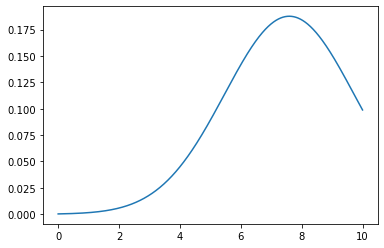

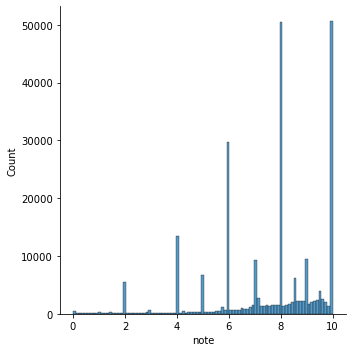

In [44]:
import matplotlib.pyplot as plt

notes = df_avis["note"]
mu  = np.mean(notes)
sig = np.std(notes)

x = np.linspace(0, 10, 1000)
y = np.exp( - (x - mu)**2 / (2 * sig**2)) / (np.sqrt(2 * np.pi) * sig)


sns.lineplot(x=x, y=y)
sns.displot(notes)

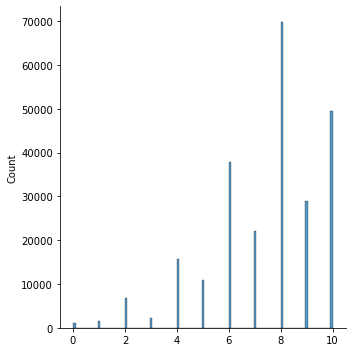

In [45]:
values_as_int = np.array(notes) // 1
sns.displot(values_as_int)